In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as pyplt
import seaborn as sns

In [25]:
og_df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
og_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [26]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [27]:
og_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [28]:
for col in og_df:
    if og_df[col].nunique() < 10:
        print(og_df[col].value_counts())
        print("\n")

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


0    4612
1     498
Name: hypertension, dtype: int64


0    4834
1     276
Name: heart_disease, dtype: int64


Yes    3353
No     1757
Name: ever_married, dtype: int64


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


0    4861
1     249
Name: stroke, dtype: int64




In [29]:
#drop id column due to its irrelevance regarding stroke prediction
df_1 = og_df.drop("id", axis=1)
df_1.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [30]:
index = df_1.index[df_1["gender"] == "Other"]
print(df_1.loc[index])

#removed the other gender since there is only one entry, leading to unnecessary complexity
df_2 = df_1.drop(index)

     gender   age  hypertension  heart_disease ever_married work_type  \
3116  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


In [31]:
#replaced NaN values in the bmi column with the average bmi
average_bmi = df_2["bmi"].mean()
df_2["bmi"].fillna(average_bmi, inplace=True)

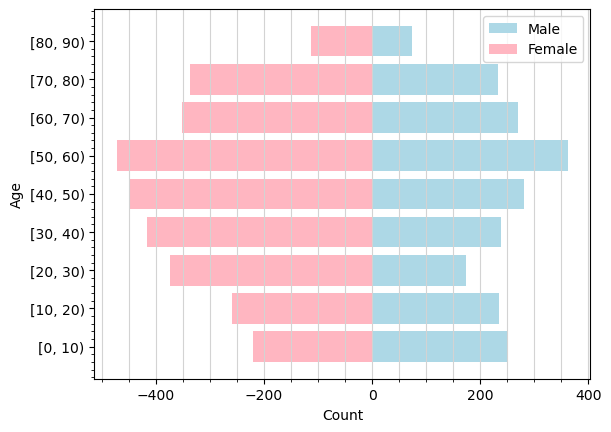

In [32]:
# Defined the age bins
bins = range(0, int(df_2["age"].max()) + 10, 10)

# Add a new column "age_group" to the DataFrame representing the age group of each person
df_2["age_group"] = pd.cut(df_2["age"], bins, right=False)

# Group by "age_group" and "gender" and get the size of each group
grouped = df_2.groupby(["age_group", "gender"]).size().unstack()


# Plot the pyramid chart
fig, ax = pyplt.subplots()

ax.barh(grouped.index.astype(str), grouped["Male"], color='lightblue', label="Male")
ax.barh(grouped.index.astype(str), -grouped["Female"], color='lightpink', label="Female")

ax.legend()
ax.minorticks_on()

ax.grid(True, axis="x", color="lightgray", which="both")

pyplt.xlabel("Count")
pyplt.ylabel("Age")

pyplt.show()

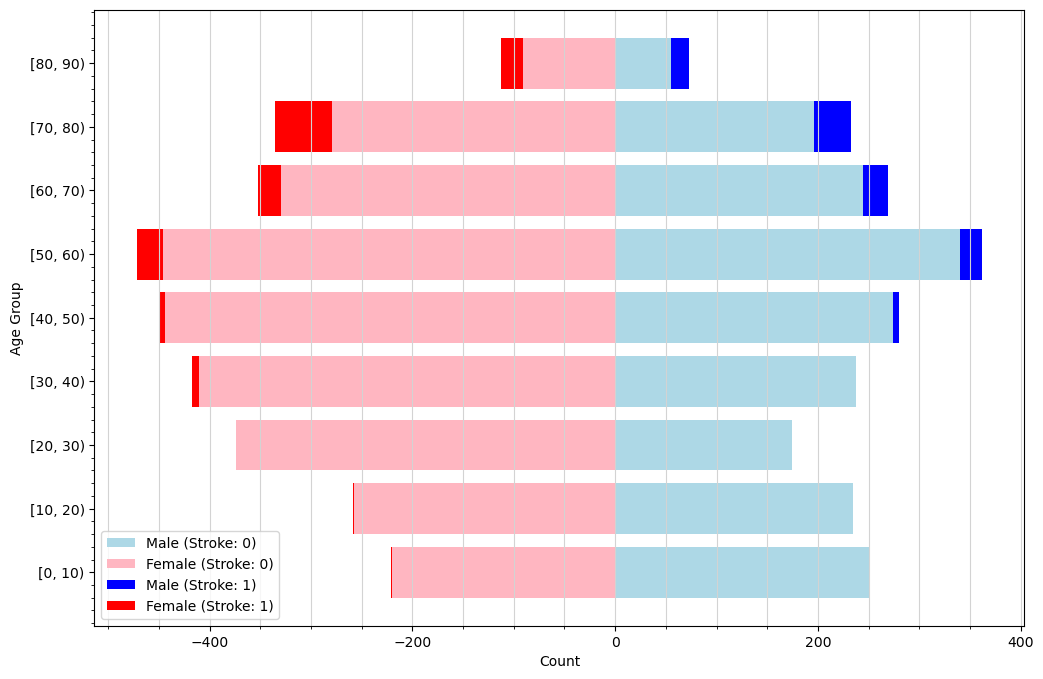

In [33]:
# Defined the age bins
bins = range(0, int(df_2["age"].max()) + 10, 10)

# Add a new column "age_group" to the DataFrame representing the age group of each person
df_2["age_group"] = pd.cut(df_2["age"], bins, right=False)

# Group by "age_group" and "gender" and "stroke" and get the size of each group
grouped = df_2.groupby(["age_group", "gender", "stroke"]).size().unstack(level=[1, 2])

#create pyramid chart
fig, ax = plt.subplots(figsize=(12, 8))

#create bar for ech group
for stroke_status in [0, 1]:
    ax.barh(
        grouped.index.astype(str), 
        grouped[("Male", stroke_status)], 
        color='lightblue' if stroke_status == 0 else 'blue', 
        label=f"Male (Stroke: {stroke_status})",
        left=grouped[("Male", 0)] if stroke_status == 1 else 0
    )
    ax.barh(
        grouped.index.astype(str), 
        -grouped[("Female", stroke_status)], 
        color='lightpink' if stroke_status == 0 else 'red', 
        label=f"Female (Stroke: {stroke_status})",
        left=-grouped[("Female", 0)] if stroke_status == 1 else 0
    )


#plot of chart
ax.legend()
ax.minorticks_on()
ax.grid(True, axis="x", color="lightgray", which="both")
plt.xlabel("Count")
plt.ylabel("Age Group")
plt.show()


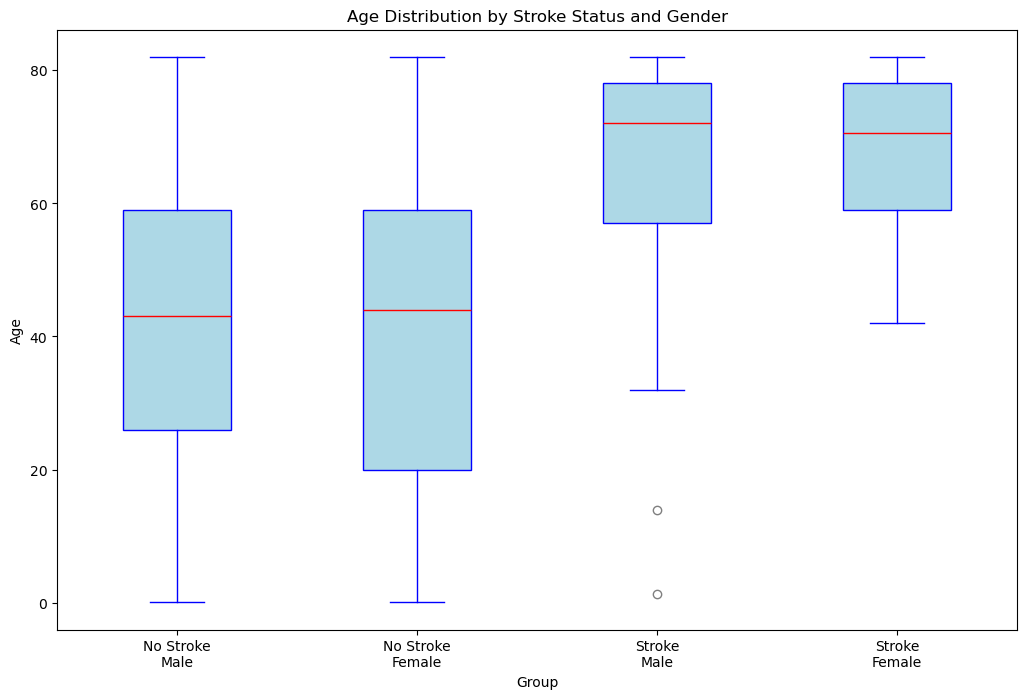

In [36]:

fig, ax = plt.subplots(figsize=(12, 8))

#create boxplot
df_2.boxplot(column='age', by=['stroke', 'gender'], ax=ax, grid=False, patch_artist=True, 
             boxprops=dict(facecolor='lightblue', color='blue'),
             medianprops=dict(color='red'),
             whiskerprops=dict(color='blue'),
             capprops=dict(color='blue'),
             flierprops=dict(marker='o', color='blue', alpha=0.5))

#add descriptions
ax.set_title('Age Distribution by Stroke Status and Gender')
ax.set_xlabel('Group')
ax.set_ylabel('Age')
plt.suptitle('')

#add x-axis
group_labels = ['No Stroke\nMale', 'No Stroke\nFemale', 'Stroke\nMale', 'Stroke\nFemale']
ax.set_xticklabels(group_labels)

#plot chart
plt.show()

c:\Users\LRunge\Anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

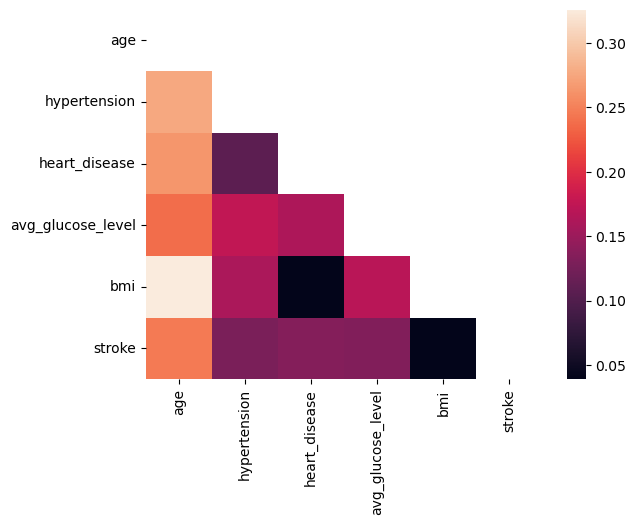

In [34]:
#select only numerical columns to create a heatmap
num_df = df_2.select_dtypes(include=['int64', 'float64'])

#calculate the correlation matrix
corr = num_df.corr()

#plot the heatmap
sns.heatmap(corr, annot=True, mask = np.triu(np.ones_like(corr, dtype=bool)))

c:\Users\LRunge\Anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

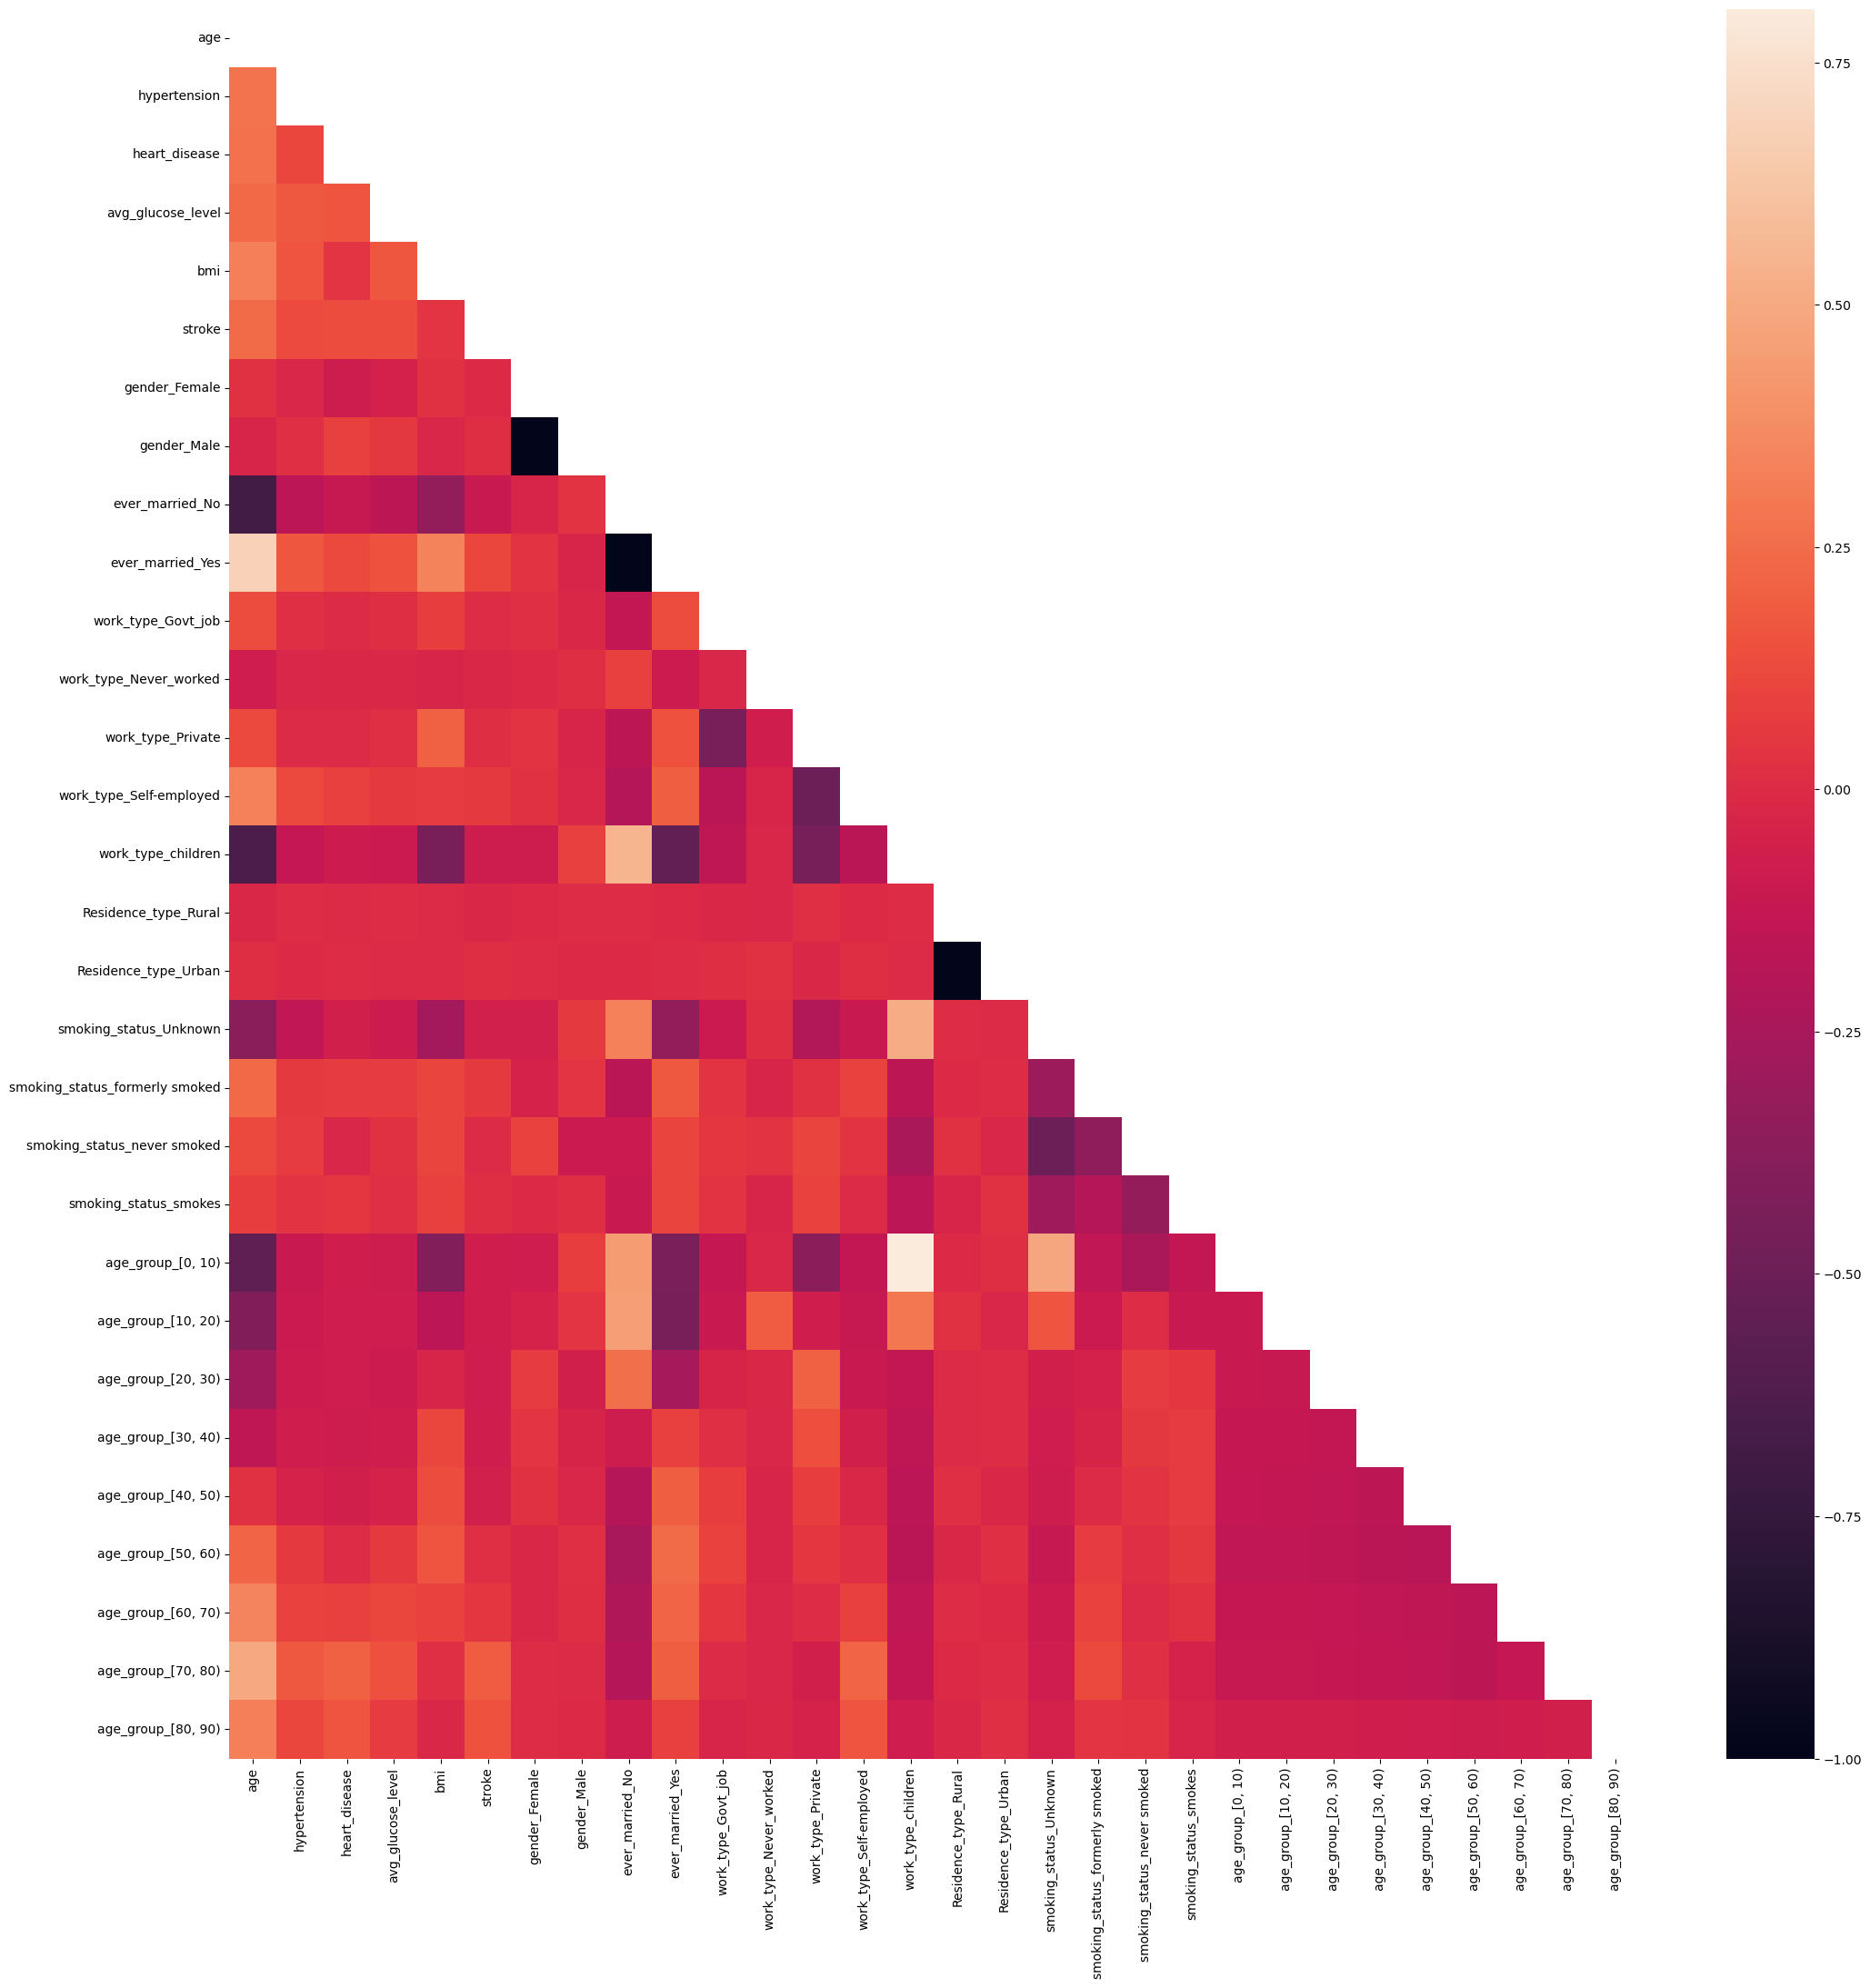

In [11]:
#select only non-numerical columns to create dummies
non_num_df = df_2.select_dtypes(exclude=['int64', 'float64'])

#convert non-numerical columns to dummies
dummies_df = pd.get_dummies(non_num_df)

#convert dummies to integers
dummies_df = dummies_df.astype(int)

#concatenate the numerical and dummies dataframes
completeNum_df = pd.concat([num_df, dummies_df], axis=1)

#calculate the correlation matrix
completeCorr = completeNum_df.corr()

#plot the heatmap
pyplt.figure(figsize=(25, 25))
sns.heatmap(completeCorr, annot=True, mask = np.triu(np.ones_like(completeCorr, dtype=bool)))
